In [1]:
import os
import tensorflow as tf

#Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'


In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

#style_path = "../input/monetpicasso/Claude-Monet-Waterlilies-and-Japanese-Bridge-1899_HIGH-RES.jpg"
#content_path = "../input/monetpicasso/Mona_Lisa_by_Leonardo_da_Vinci_from_C2RMF_retouched.jpg"
style_1 = "../input/artstyledatatest/578ade4d39c16e581db80eb60a506088.jpg"
style_2 = "../input/artstyledatatest/Caravaggio.jpeg"
style_3 = "../input/artstyledatatest/Henri Matisse.jpeg"
style_4 = "../input/artstyledatatest/IMG_8434.jpeg"
style_5 = "../input/artstyledatatest/Jackson Pollock.jpeg"
style_6 = "../input/artstyledatatest/The_Great_Wave_off_Kanagawa.jpeg"
style_7 = "../input/artstyledatatest/art.jpg"
style_8 = "../input/artstyledatatest/georges seurat.jpeg"
style_9 = "../input/artstyledatatest/the-weeping-woman.jpeg"

img_1 = "../input/image-style/1_nyhavn.jpeg"
img_2 = "../input/image-style/2_us.jpg"
img_3 = "../input/image-style/3_istockphoto-1042882838-612x612.jpg"
img_4 = "../input/image-style/4_lama-2015-arizona-washington-wallpaper-preview.jpg"
img_5 = "../input/image-style/5_michael.jpg"
img_6 = "../input/image-style/6_aLTFQx.jpg"
img_7 = "../input/hedgehog/7_GettyImages-1053735888-scaled.jpg"
img_8 = "../input/image-style/8_officecanren.jpg"
img_9 = "../input/image-style/9_wp2048463.jpg"
img_10 = "../input/circle/10.jpg"

In [6]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [7]:
def imshow(image, title=None):
    if(len(image.shape) > 3):
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

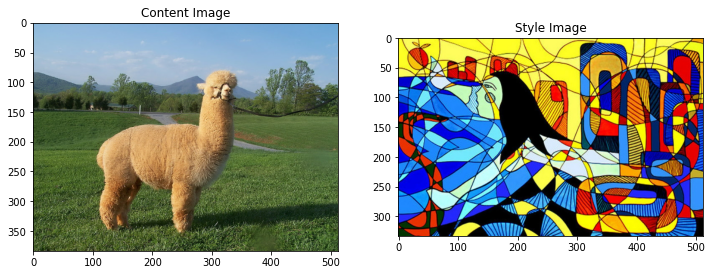

In [27]:
content_image = load_img(img_4)
style_image = load_img(style_4)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 2s 0us/step


TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('matchstick', 0.08228392),
 ('nematode', 0.06135638),
 ('digital_clock', 0.031091364),
 ('lighter', 0.027754925),
 ('spotlight', 0.024523588)]

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 333, 512, 64)
  min:  0.0
  max:  819.9868
  mean:  47.236103

block2_conv1
  shape:  (1, 166, 256, 128)
  min:  0.0
  max:  7969.6475
  mean:  262.83392

block3_conv1
  shape:  (1, 83, 128, 256)
  min:  0.0
  max:  11895.092
  mean:  380.04187

block4_conv1
  shape:  (1, 41, 64, 512)
  min:  0.0
  max:  31289.557
  mean:  1172.8296

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  3541.3862
  mean:  77.244514



In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  179521.48
    mean:  539.7351

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  321311.8
    mean:  14524.789

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  436690.16
    mean:  11572.956

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5136473.5
    mean:  129498.3

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  85159.945
    mean:  615.28864

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  859.75946
    mean:  6.4922276


In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
image = tf.Variable(content_image)

In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [22]:
style_weight=1e-2
content_weight=1e4

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [24]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


2022-05-02 14:52:26.562838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


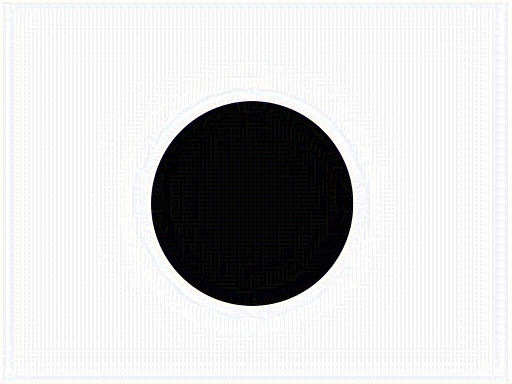

In [25]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

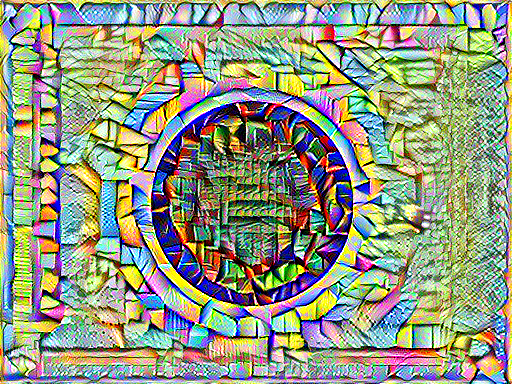

Train step: 375
Total time: 818.0


In [26]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 25

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
tensor_to_image(image).save("output.jpg")